# Sistemas híbridos


*Autómatos híbridos* são modelos de sistemas ciber-físicos. Essencialmente um autómato híbrido é uma *máquina de estados finita*, onde cada estado (designado por *modo de funcionamento*) descreve o comportamento contínuo de um sistema dinâmico modelado por *relações diferenciais ordinárias* (nas variáveis contínuas e nas suas derivadas em relação ao tempo) codificadas num predicado designado por *flow*. Estas variáveis contínuas evoluem num modo de funcionamento enquanto o seu *flow* for válido.
Cada transição discreta entre estados (um *switch* entre modos de funcionamento) é representada por um arco anotado com um evento e um predicado (*jump*). O *switch* realiza-se quando o seu *jump* é válido. Ao ocorrer uma transição as variáveis internas dos modos conservam o seu valor, a não ser que lhes seja explicitamente atribuído um novo valor.

*Sistemas híbridos* são modelos constituídos por vários autómatos híbridos que, em princípio, evoluem de forma “quase-independente”; a única dependência manifesta-se no sincronismo de duas ou mais transições relativas ao mesmo evento em autómatos distintos.

Um sistema híbrido pode ser descrito por um FOTS (sobre o qual podemos verificar propriedades lógicas com as metodologias que já estudamos). Nesse processo o FOTS vai *discretizar* as relações diferenciais ordinárias e vai mapea-las num espaço de estados também discreto.




## Verificação de autómatos híbridos com FOTS

Podemos verificar propriedades de segurança de autómatos híbridos codificando a semântica dos mesmos num FOTS e usando depois os procedimentos de verificação implementados nas aulas anteriores.

A ideia básica é incluir nos estados do FOTS para além das variáveis contínuas do autómato híbrido duas variáveis especiais:
- uma variável contínua que denota o tempo ($t$ no caso do termostato)
- uma variável discreta que denota o *modo de funcionamento* ($m$ no caso do termostato)

O estado inicial do FOTS é derivado facilmente a partir da definição do autómato híbrido. Por exemplo, no caso do termostato temos

$$
t = 0 \wedge m = \mathsf{INIT} \wedge x = 20
$$

As transições do FOTS incluem os dois tipos de transição que podem ocorrer num autómato híbrido:
- Transições *timed* descrevem os *flows* associados a cada modo (a evolução das variáveis contínuas)
- Transições *untimed* descrevem os *switches* entre modos

As transições *untimed* podem ser obtidas através de uma codificação muito directa das guardas e efeitos especificadas nos *switches*, com a restrição que o tempo não evolui nestas transições, nem as variáveis contínuas se modificam a não ser que lhes seja explicitamente atribuído um novo valor no efeito do *switch*. Por exemplo, no caso do termostato temos 3 transições deste tipo:

$$
\begin{array}{c}
m = \mathsf{INIT} \wedge m' = \mathsf{OFF} \wedge x' = x \wedge t' = t \\
\vee\\
m = \mathsf{OFF} \wedge m' = \mathsf{ON} \wedge x < 19 \wedge x' = x \wedge t' = t \\
\vee\\
m = \mathsf{ON} \wedge m' = \mathsf{OFF} \wedge x \ge 21 \wedge x' = x \wedge t' = t 
\end{array}
$$

Nas transições *timed* o modo permanece constante, mas o resto das variáveis evoluem de acordo com as restrições indicadas. Os *flows* são especificados indicando qual a derivada em relação ao tempo de cada variável contínua. Para codificar os *flows* no FOTS é necessário fazer a sua *discretização*, ou seja, indicar qual a variação ocorrida num intervalo de tempo $t'-t$. Se a derivada for uma constante a discretização é trivial. Por exemplo, se $\dot{x} = k$ temos que $x' - x = k(t'-t)$. 
Se a relação de *flow* é amortecida, como por exemplo no modo $\mathsf{OFF}$ do termostato, uma pseudo-solução seria aproximar a derivada $\dot{x}$ por $\frac{x'-x}{t'-t}$ obtendo-se
$5(x' - x) + x*(t'-t) = 0$, mas nesta equação ocorre um produto não-escalar $\,x*(t'-t)\,$ e, por isso,  ela não vai ser decidível.
Uma sugestão para discretizar consiste em usar um valor constante para substituir a variável $x$, inferido a partir do invariante de modo. Neste caso a equação de flow transforma-se numa inequação.


Por exemplo, no caso do *flow* associado ao modo $\mathsf{OFF}$, $5\dot{x}+x=0$,  como sabemos que $x \ge 18$ podemos substituir $x$ por 18 na equação, dando origem à relação $x' - x \le -\frac{18}{5}(t'-t)$. 
No caso do *flow* associado ao modo $\mathsf{ON}$, $5\dot{x}+x=25$,  como $x \le 22$ podemos aproximar $x$ por 22, dando origem à relação $x' - x \ge \frac{3}{5}(t'-t)$. 

Finalmente, é necessário também impor os invariantes dos modos no FOTS. Isso pode ser feito acrescentando a cada transição uma restrição que obriga o invariante a ser cumprido. Temos também que assugurar que o tempo avança.


Com esta técnica, no caso do termostato teríamos as seguintes duas transições *timed*:

$$
\begin{array}{c}
m = \mathsf{OFF} \wedge m' = m \wedge x' - x \le -\frac{18}{5}(t'-t) \wedge x \ge 18 \wedge x' \ge 18 \wedge t'>t \\
\vee\\
m = \mathsf{ON} \wedge m' = m \wedge x' - x \ge \frac{3}{5}(t'-t) \wedge x \le 22 \wedge x' \le 22 \wedge t' > t
\end{array}
$$

Para reduzir os erros na verificação pode-se reduzir a granularidade da discretização subdividindo cada modo em vários sub-modos que cubram toda a gama dos valores permitidos. Por exemplo neste caso poderíamos dividir cada um dos modos em 4 sub-modos, cada um com uma variação de temperatura máxima de 1 grau, cobrindo assim toda a gama de temperaturas possíveis (entre 18 e 22 graus).

Começamos por importar as bibliotecas do pySMT e, como o pySMT não permite ainda definir um tipo enumerado para implementar os modos do termostato, vamos usar três valores inteiros par os representar.

In [3]:
from pysmt.shortcuts import *
from pysmt.typing import *

INIT = Int(-1)
OFF = Int(0)
ON = Int(1)

Podemos agora declarar as variáveis do FOTS correspondente ao termostato da seguinte forma.

In [4]:
def declare(i):
    s = {}
    s['t'] = Symbol('t'+str(i),REAL)
    s['m'] = Symbol('m'+str(i),INT)
    s['x'] = Symbol('x'+str(i),REAL)
    return s

### Exercício 1

Codifique os predicados `init` e `trans` que caracterizam, respectivamente, os estados iniciais e as transições do FOTS correspondente ao termostato.

In [5]:
def init(s):
        # completar
        return And(Equals(s['m'],INIT),Equals(s['x'],Real(20)),Equals(s['t'],Real(0)))
s = declare(0)
print(init(s))
def trans(s,p):
    # completar
    # untimed
    initoff = And(Equals(s['m'],INIT), Equals(p['m'], OFF), Equals(p['x'],s['x']), Equals(p['t'],s['t']))
    offon = And(Equals(s['m'],OFF), Equals(p['m'], ON), s['x'] < 19, Equals(p['x'],s['x']), Equals(p['t'],s['t']))
    onoff = And(Equals(s['m'],ON), Equals(p['m'], OFF), s['x'] >= 21, Equals(p['x'],s['x']), Equals(p['t'],s['t']))
    
    #timed
    offoff = And(Equals(s['m'],OFF), Equals(p['m'], OFF),
                p['t'] > s['t'], s['x'] >= Real(18), p['x'] >= Real(18),
                p['x'] - s['x'] <= -Div(Real(18),Real(5)) * (p['t'] - s['t']))
    onon = And(Equals(s['m'],ON), Equals(p['m'], ON),
                p['t'] > s['t'], s['x'] <= Real(22), p['x'] <= Real(22),
                p['x'] - s['x'] >= Div(Real(3),Real(5)) * (p['t'] - s['t']))
    
    return Or([initoff,offon,onoff,offoff,onon])

((m0 = -1) & (x0 = 20.0) & (t0 = 0.0))


### Exercício 2

Adapte a função `gera_traco` implementada nas aulas anteriores por forma a imprimir todas as variáveis contínuas como números de virgula flutuante. 
Para obter o valor de uma variável num tipo Python use o método `get_py_value`. Verá que os valores voão aprecer como frações. Converta estes valores para um float do Python usando a função `float`.

In [6]:
def gera_traco(declare,init,trans,k):
    with Solver(name="z3") as s:
        
        # completar
        trace = [declare(i) for i in range(k)]
        
        #semantics
        s.add_assertion(init(trace[0]))
        for i in range(k-1):
            s.add_assertion(trans(trace[i], trace[i+1]))
            
        if s.solve():
            '''
            m = s.get_model()
            for n, v in m:
                print(f'{n} = {v}')
            '''
            for i in range(k):
                print("Passo ",i)
                for v in trace[i]:
                    print(v, "=", s.get_value(trace[i][v]))
                print("------------------------")
    
                        
####
gera_traco(declare,init,trans,5)

Passo  0
t = 0.0
m = -1
x = 20.0
------------------------
Passo  1
t = 0.0
m = 0
x = 20.0
------------------------
Passo  2
t = 5/9
m = 0
x = 18.0
------------------------
Passo  3
t = 5/9
m = 1
x = 18.0
------------------------
Passo  4
t = 10/9
m = 1
x = 55/3
------------------------


### Exercício 3

Adapte a função `bmc_always` implementada nas aulas anterior para, tal como no exercício anterior, quando ocorrer um contra-exemplo imprima também todas as variáveis continuas como números de virgula flutuante. 

In [5]:
def bmc_always(declare,init,trans,prop,K):
    for k in range(1,K+1):
        with Solver(name="z3") as s:
            
            # completar
            trace = [declare(i) for i in range(k)]
        
            # adicionar o estado inicial 
            s.add_assertion(init(trace[0]))

            for i in range(k-1):
                s.add_assertion(trans(trace[i], trace[i+1]))
                
            # adicionar a negaçao do invariante
            s.add_assertion(Not(prop(trace[k-1])))

            if s.solve():
                '''
                m = s.get_model()
                for n, v in m:
                    print(f'{n} = {v}')
                '''
                for i in range(k):
                    print("Passo ",i)
                    for v in trace[i]:
                        print(v, "=", s.get_value(trace[i][v]))
                    print("------------------------")
                print("A propriedade nao e invariante")
                return

    print(f'O invariante mantém-se nos primeiros {k} passos')


            
    
######

def nonnegative(s):
    return (s['x'] >= Real(0))

bmc_always(declare,init,trans,nonnegative,20)

O invariante mantém-se nos primeiros 20 passos


### Exercício 4

A propriedade "o termostato irá inevitavelmente estar ligado" é uma propriedade de *liveness* exprimível como $F\ (m = \mathsf{ON})$. No entanto a propriedade "passado 1 segundo o termostato irá inevitavelmente estar ligado" já é uma propriedade de *safety*. Explique porquê e verifique também se esta propriedade se verifica no termostato.

In [6]:
# completar

# Safety , pq pode ser refutada por uma sequecnai finita de esados

def oneON(s):
    return Implies(Equals(s['t'],Real(1)), Equals(s['m'],ON))

bmc_always(declare,init,trans,oneON,20)

Passo  0
t = 0.0
m = -1
x = 20.0
------------------------
Passo  1
t = 0.0
m = 0
x = 20.0
------------------------
Passo  2
t = 1/2
m = 0
x = 18.0
------------------------
Passo  3
t = 1/2
m = 1
x = 18.0
------------------------
Passo  4
t = 1.0
m = 1
x = 21.0
------------------------
Passo  5
t = 1.0
m = 0
x = 21.0
------------------------
A propriedade nao e invariante


### Exercício 5

Como pode verificar o contra-exemplo obtido não é realista e deve-se à aproximação feita na discretização, que permite mais comportamentos que os realmente possíveis no sistema real. Isto faz com que seja possível termos falsos contra-exemplos para algumas propriedades. Para reduzir estes falsos contra-exemplos podemos tentar melhorar essa discretização, por exemplo, tentando inferir invariantes mais fortes para as variáveis contínuas em cada um dos modos. No caso do termostato sabemos que em qualquer dos modos de facto temos que $18 \le x \le 22$. Usando esta informação refine a definição do predicado `trans` e volte a verificar a propriedade. Se o contra-exemplo continuar a ser claramente inválido podemos refinar mais cada um dos modos, desdobrando-os para gamas da variável $x$ mais apertadas, por exemplo, dividindo cada um deles em 2 sub-modos onde $18 \le x \le 20$ e $20 \le x \le 22$.

In [7]:
# completar

def trans(s,p): # falta coisas
    # completar
    # untimed
    initoff = And(Equals(s['m'],INIT), Equals(p['m'], OFF), Equals(p['x'],s['x']), Equals(p['t'],s['t']))
    offon = And(Equals(s['m'],OFF), Equals(p['m'], ON), s['x'] < 19, Equals(p['x'],s['x']), Equals(p['t'],s['t']))
    onoff = And(Equals(s['m'],ON), Equals(p['m'], OFF), s['x'] >= 21, Equals(p['x'],s['x']), Equals(p['t'],s['t']))
    
    #timed
    offoff = And(Equals(s['m'],OFF), Equals(p['m'], OFF),
                p['t'] > s['t'], s['x'] >= Real(18), p['x'] >= Real(18),
                p['x'] - s['x'] <= -Div(Real(18),Real(5)) * (p['t'] - s['t']),
                p['x'] - s['x'] >= -Div(Real(22),Real(5)) * (p['t'] - s['t']))
    onon = And(Equals(s['m'],ON), Equals(p['m'], ON),
                p['t'] > s['t'], s['x'] <= Real(22), p['x'] <= Real(22),
                p['x'] - s['x'] >= Div(Real(3),Real(5)) * (p['t'] - s['t']),
                p['x'] - s['x'] <= Div(Real(7),Real(5)) * (p['t'] - s['t']))
    
    return Or([initoff,offon,onoff,offoff,onon])

### Exercício 6

Considere o seguinte autómato híbrido que modela um contador que no modo $\mathsf{ON}$ evolui síncronamente com o tempo. Neste caso vamos assumir que a variável de tempo é designada $\tau$ e variável de modo por $n$.


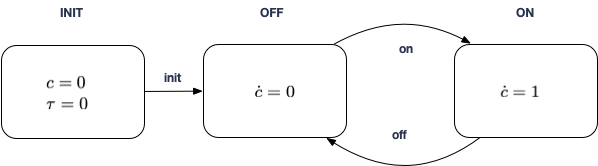


Modele este autómato com um FOTS e verifique que o valor do contador nunca é superior ao tempo decorrido.

In [8]:
# completar

def declare(i):
    s = {}
    s['u'] = Symbol('t'+str(i),REAL)
    s['n'] = Symbol('m'+str(i),INT)
    s['c'] = Symbol('x'+str(i),REAL)
    return s

## Verificação de sistemas híbridos com FOTS

Se quisermos verificar propriedades sobre um sistema híbrido, por exemplo, sobre o sistema que incluiu os dois autómatos acima, temos que modelar a evolução de todos os seus autómatos num único FOTS. Os estados deste FOTS correspondem ao produto cartesiano dos estados dos vários autómatos, sendo o estado inicial caracterizado pela conjunção dos predicados iniciais de todos eles. Por exemplo, num sistema híbrido com um termostato e um contador,  o estado inicial seria caracterizado pelo seguinte predicado.

$$
m = \mathsf{INIT} \wedge x = 20 \wedge t = 0 \wedge n = \mathsf{INIT} \wedge c = 0 \wedge \tau = 0
$$

Para tal temos que considerar como é que as transições dos diferentes autómatos estão sincronizadas:

- as transições *timed* de diferentes autómatos ocorrem simultaneamente sse o intervalo de tempo decorrido for igual em todos os *flows*
- as transições *untimed* de diferentes autómatos ocorrem simultaneamente sse o evento que ocorre for igual em todos os *switches*

No sistema híbrido exemplo, a transição *untimed* relativa ao evento $\mathsf{init}$ seria caracterizada pela seguinte restrição.

$$
m = \mathsf{INIT} \wedge m' = \mathsf{OFF} \wedge x' = x \wedge t' = t \wedge n = \mathsf{INIT} \wedge n' = \mathsf{OFF} \wedge c' = c \wedge \tau' = \tau
$$

No caso das transições *timed* temos que considerar todas as combinações de transições *timed* nos diferentes modos. Por exemplo, quando os dois autómatos estão no estado $\mathsf{OFF}$ o *flow* pode ser caracterizado pela seguinte restrição (sem considerar o refinamento introduzido no exercício 5).

$$
\begin{array}{c}
m = \mathsf{OFF} \wedge m' = m \wedge x' - x \le -\frac{18}{5}(t'-t) \wedge x \ge 18 \wedge x' \ge 18 \wedge t'>t\\
\wedge\\
n = \mathsf{OFF} \wedge n' = n \wedge c' - c = 0 \wedge \tau' > \tau\\
\wedge\\
t' - t = \tau' - \tau
\end{array}
$$

### Exercício 7

Modele este sistema híbrido em Z3 e gere um traço com 5 estados.

In [9]:
# completar

### Exercício 8

Verifique que o contador é positivo passados pelo menos 0.2 segundos.

In [10]:
# completar